In [1]:
%load_ext autoreload
%autoreload 2
# Add parent directory into system path
import sys, os
sys.path.insert(1, os.path.abspath(os.path.normpath('..')))

In [2]:
import torch
from torch import nn
from torch.nn.init import calculate_gain
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f'CUDA {i}: {torch.cuda.get_device_name(i)}')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float32)

CUDA 0: NVIDIA GeForce GTX 1650 Ti


In [3]:
from models import MLP_PINN_RAR
net = MLP_PINN_RAR(N_layers=8, width=32, activation=nn.ELU()).to(device)

In [17]:
import os
from utils.dataset import ImplicitDataset, RandomMeshSDFDataset

dataset_name = '../datasets/box_1f0_gyroid_4pi'
output_stl = dataset_name+'.stl'
#train_dataset = ImplicitDataset.from_file(file=dataset_name+'_train.npz', device=device)
train_dataset = RandomMeshSDFDataset(output_stl, sampling_method='importance', M=int(1e6), W=10, device=device)
print(train_dataset)

use_random_sdf = isinstance(train_dataset, RandomMeshSDFDataset)
points = train_dataset.points if use_random_sdf else train_dataset.pde_points
points.requires_grad_(True)
sdfs = train_dataset.sdfs if use_random_sdf else train_dataset.bc_sdfs

RandomMeshSDFDataset (10000 points)


In [11]:
from utils.optimizer import CallbackScheduler

# Optimization
## ADA
optimizer=torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-6, amsgrad=False)
lr_scheduler = CallbackScheduler([
    CallbackScheduler.reduce_lr(0.2),
    CallbackScheduler.reduce_lr(0.2),
    CallbackScheduler.init_LBFGS(
        lr=1, max_iter=20, max_eval=40, 
        tolerance_grad=1e-5, tolerance_change=1e-9,
        history_size=100,
        line_search_fn=None
    ),
    CallbackScheduler.reduce_lr(0.2)
], optimizer=optimizer, model=net, eps=1e-7, patience=300)

In [18]:
max_epochs = 3000
PRINT_EVERY_EPOCH = 100
RAR_START = 100
try:
    for epoch in range(max_epochs):
        # Training
        optimizer.zero_grad()
        y = net(new_points if epoch > RAR_START else points)
        loss = net.loss(y, new_points if epoch > RAR_START else points, points, sdfs)
        loss.backward(retain_graph=True)
      
        lr_scheduler.optimizer.step(lambda: loss)
        lr_scheduler.step_when((epoch % 500) == 499)
        lr_scheduler.step_loss(loss)                

        if epoch % PRINT_EVERY_EPOCH == 0:
            print(f'#{epoch} Loss: {net._loss_PDE:.6f}, {net._loss_SDF:.6f}')
        
        if epoch == RAR_START:
            extra_points = net.adjust_samples_from_residual(net(points), points, num_samples=points.shape[0]*1.5)
            new_points = torch.cat((points, extra_points))
        
except KeyboardInterrupt as e:
    print('Bye bye')


#0 Loss: 0.004686, 0.006345
#100 Loss: 0.002878, 0.006835
#200 Loss: 0.002700, 0.006815
#300 Loss: 0.002482, 0.006689
#400 Loss: 0.002424, 0.006532
#500 Loss: 0.002369, 0.006397
#600 Loss: 0.002357, 0.006244
#700 Loss: 0.002291, 0.006161
#800 Loss: 0.002281, 0.006029
#900 Loss: 0.002274, 0.005926
#1000 Loss: 0.002237, 0.005862
#1100 Loss: 0.002220, 0.005790
#1200 Loss: 0.002196, 0.005698
#1300 Loss: 0.002179, 0.005607
#1400 Loss: 0.002185, 0.005490
Bye bye


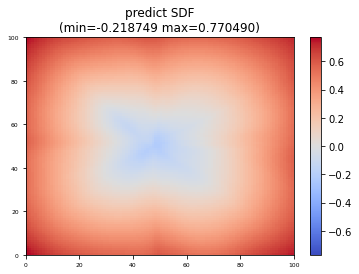

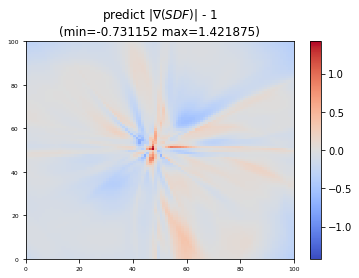

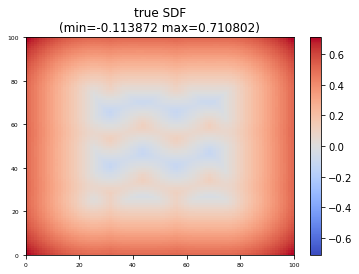

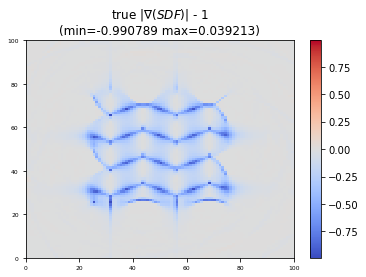

In [19]:
from utils import SDFVisualize, plot_model_weight
visualize = SDFVisualize(z_level=0, step=0.05, offset=30, nums=100, device=device)
visualize.from_nn(net, bounds_from_mesh=output_stl)
visualize.from_mesh(output_stl)